# [G-10] Transformer translator

In [47]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

1. 입력 데이터 → `[ batch_size x length ]`
2. Source & Target Embedding → `[ batch_size x length x d_emb ]`
3. Positional Encoding 강의 노드에서 구현을 했었죠? 2번의 결과에 더해지므로 shape 변화는 없습니다.
4. Multi-Head Attention 아래와 같이 여러 개의 서브 모듈들이 존재합니다.
   1) Split Heads →`[ batch_size x length x heads x (d_emb / n_heads) ]`
   2) Masking for Masked Attention
   3) Scaled Dot Product Attention
   4) Combine Heads →`[ batch_size x length x d_emb ]`
5. Residual Connection
6. Layer Normalization
7.  Position-wise Feed-Forward Network → `[ batch_size x length x d_ff ]`
8.  Output Linear Layer → `[ batch_size x length x vocab_size ]`

In [48]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.4.1


# 데이터 정제

In [49]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng) # kor eng 쌍

    cleaned_corpus = []
    for sen_pair in zip(kor, eng):
        cleaned_corpus.append(sen_pair)
    cleaned_corpus = list(set(cleaned_corpus))
    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [50]:
cleaned_corpus[:3]

[('Obama unveils the 3 trillion dollar budget 오바마 대통령, 3조억 달러에 이르는 예산 발표\xa0 \xa0 \xa02009.06',
  'President Barack Obama, meanwhile, has picked a former shuttle commander to head the space agency.'),
 ('라며 “그에 대한 새로운 정보와 몽타쥬를 제공해 이 사건이 해결됐으면 한다”고 말했다.',
  'We\'re providing new information and pictures and asking for your help in solving the case," the FBI said in a statement.'),
 ('전쟁으로 파괴된 이라크 문제를 협의하기 위해 미국과 이란 외교관이 회담을 가질 것이라고 영국 행정관이 밝혔다.',
  'The U.S. and Iranian ambassadors to Iraq will meet this week to discuss security issues in the war-torn country, a senior Bush administration official said Sunday.')]

- 모든 입력을 소문자로 변환합니다.
- 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
- 문장부호 양옆에 공백을 추가합니다.
- 문장 앞뒤의 불필요한 공백을 제거합니다.

In [51]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower()
    sentence = re.sub(r"[^0-9가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

### Sentencepiece로 토크나이징   
https://github.com/google/sentencepiece

In [52]:
import sentencepiece as spm

def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    temp_file = os.getenv('HOME') + f'/aiffel/transformer/corpus_{lang}.txt'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix=spm_{lang} --vocab_size={vocab_size}'
    )
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'spm_{lang}.model')

    return tokenizer

In [53]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k = pair[0]
    e = pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [54]:
tokensIDs = ko_tokenizer.EncodeAsIds(cleaned_corpus[0][0])
print(tokensIDs)

[4, 3, 1051, 10364, 14138, 61, 162, 47, 4572, 19224, 16652, 1347, 999, 17232, 1014, 99, 90, 13, 47, 478, 257, 3847, 2768, 2772, 310, 1203, 19998, 3712]


In [55]:
tokensIDs = ko_tokenizer.encode_as_pieces(cleaned_corpus[0][0])
print(tokensIDs)

['▁', 'O', 'b', 'ama', '▁unveil', 's', '▁the', '▁3', '▁tr', 'illion', '▁dollar', '▁b', 'u', 'dge', 't', '▁오바마', '▁대통령', ',', '▁3', '조', '억', '▁달러에', '▁이르는', '▁예산', '▁발표', '▁2009', '.', '06']


In [56]:
from tqdm.notebook import tqdm

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50:
        src_corpus.append(src)
        tgt_corpus.append(tgt)

enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

# 모델 설계

In [57]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [58]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [59]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [60]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [61]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [62]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [63]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [64]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [65]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [66]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [67]:
learning_rate = LearningRateScheduler(512)

In [68]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [69]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [70]:
# train step
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [71]:
transformer = Transformer(n_layers=2, 
                          d_model=512, 
                          n_heads=8, 
                          d_ff = 2048, 
                          src_vocab_size=SRC_VOCAB_SIZE, 
                          tgt_vocab_size=TGT_VOCAB_SIZE, 
                          pos_len=200, 
                          dropout=0.1, 
                          shared=True)

In [72]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [73]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)
    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=enc_train.shape[-1], padding='post')
    
    print(len(_input))
    print(enc_train.shape[-1])

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)
        
        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)
        
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tgt_tokenizer.decode_ids(ids)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [74]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [75]:
examples = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

In [76]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20


for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is the presidential candidate
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: they are also beenough .
1
50
Input: 커피는 필요 없다.
Predicted translation: it is not to be they .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: they were killed in the area of the areas .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is also a presidential nominee .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is also around the city .
1
50
Input: 커피는 필요 없다.
Predicted translation: no needs to be no needs .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed and wounded .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is also very very very very , but also about they re , obama also saying .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is normally in the city .
1
50
Input: 커피는 필요 없다.
Predicted translation: they are very well , but some are needed to be around .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven other dead were killed .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama has been taken into office .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is a city .
1
50
Input: 커피는 필요 없다.
Predicted translation: there is a little bit of a lot of caffeine .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people were killed .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is president barack obama .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: they re in urban areas .
1
50
Input: 커피는 필요 없다.
Predicted translation: it is not just a long time .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seventh fatality in the seven hours .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama leads president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a city of the city .
1
50
Input: 커피는 필요 없다.
Predicted translation: never before anybodyed out .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were injured .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: president obama has a huge president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in cities are the city .
1
50
Input: 커피는 필요 없다.
Predicted translation: never before there .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the city government may have been in the city .
1
50
Input: 커피는 필요 없다.
Predicted translation: never before , he was there .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were injured .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama term
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: city wore in city .
1
50
Input: 커피는 필요 없다.
Predicted translation: it s never until he was a alert .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama s president is expected to be president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: they re only the city .
1
50
Input: 커피는 필요 없다.
Predicted translation: it s not enough .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a seven wonder person was killed .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: president obama barack obama .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: they re busy going .
1
50
Input: 커피는 필요 없다.
Predicted translation: it never d been a coffee .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the city makes it in city .
1
50
Input: 커피는 필요 없다.
Predicted translation: it never take .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama presidents are scheduled to be president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: the city new city
1
50
Input: 커피는 필요 없다.
Predicted translation: never , or for coffee .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a seven year old sea injured seven people .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: they re series erupted .
1
50
Input: 커피는 필요 없다.
Predicted translation: en never until , he should not be in any .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is president with president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: they re on the city center .
1
50
Input: 커피는 필요 없다.
Predicted translation: it never been .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were at least seven people were killed .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: they re only the mountain .
1
50
Input: 커피는 필요 없다.
Predicted translation: it never coffee .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were dead were around the seven dead .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: they publicly focus on the city .
1
50
Input: 커피는 필요 없다.
Predicted translation: never before , he had nobody in its front entry
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were killed in the seven incidents .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: the president elect is president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: some of the urbanites haveaned .
1
50
Input: 커피는 필요 없다.
Predicted translation: or never , he s there s a data , or no one he s done .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a seven year old died in his health .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: they re doing city snow .
1
50
Input: 커피는 필요 없다.
Predicted translation: never he s no one step .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a seven year old dead were wounded .


  0%|          | 0/1047 [00:00<?, ?it/s]

1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is president .
1
50
Input: 시민들은 도시 속에 산다.
Predicted translation: they re consumed in city .
1
50
Input: 커피는 필요 없다.
Predicted translation: he never made , he said .
1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were at the seven serious debris .


1
50
Input: 오바마는 대통령이다.
Predicted translation: obama is president .
Encoder Layer 1


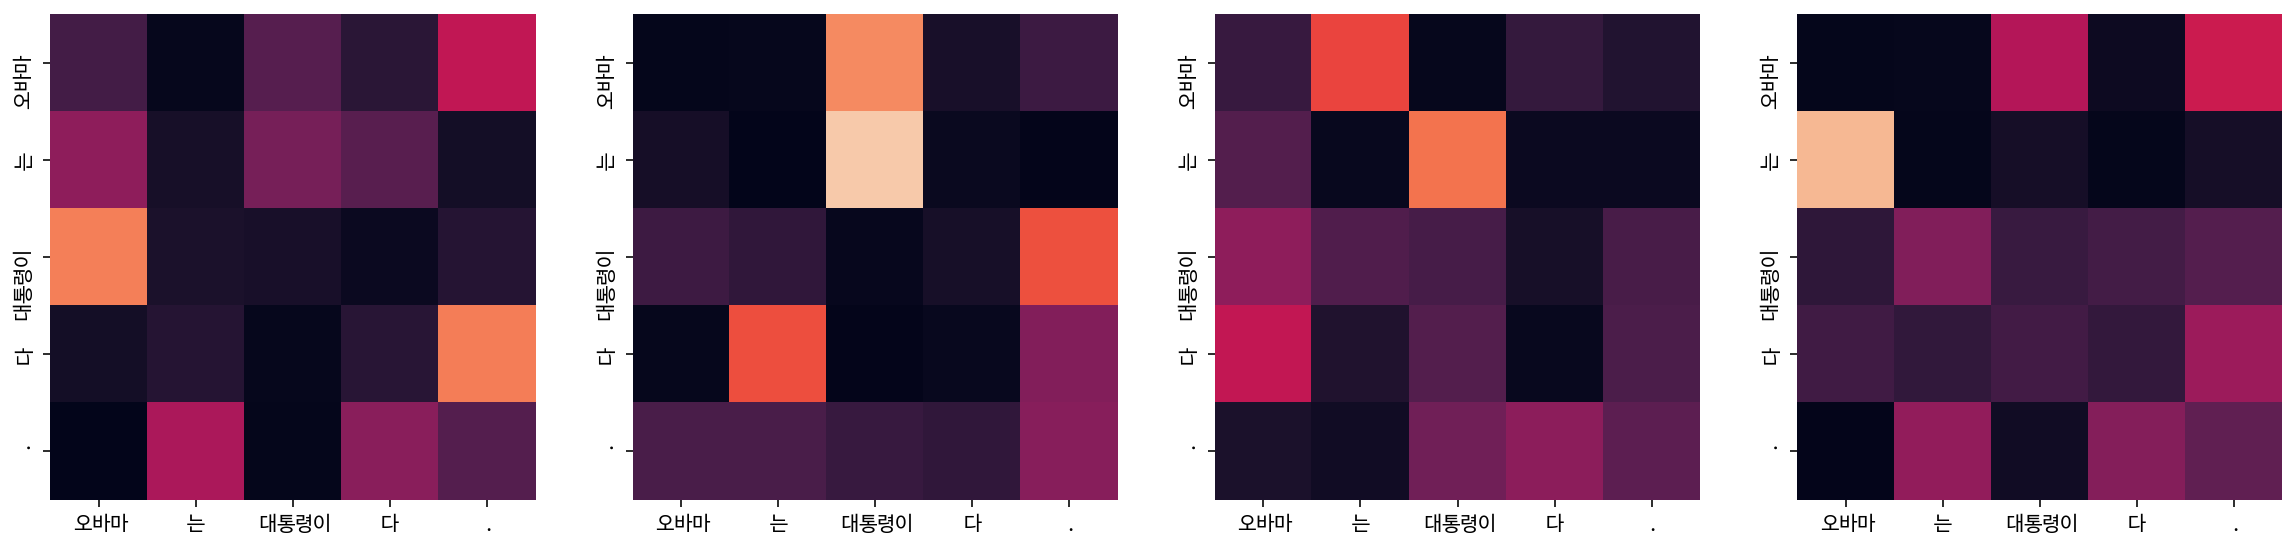

Encoder Layer 2


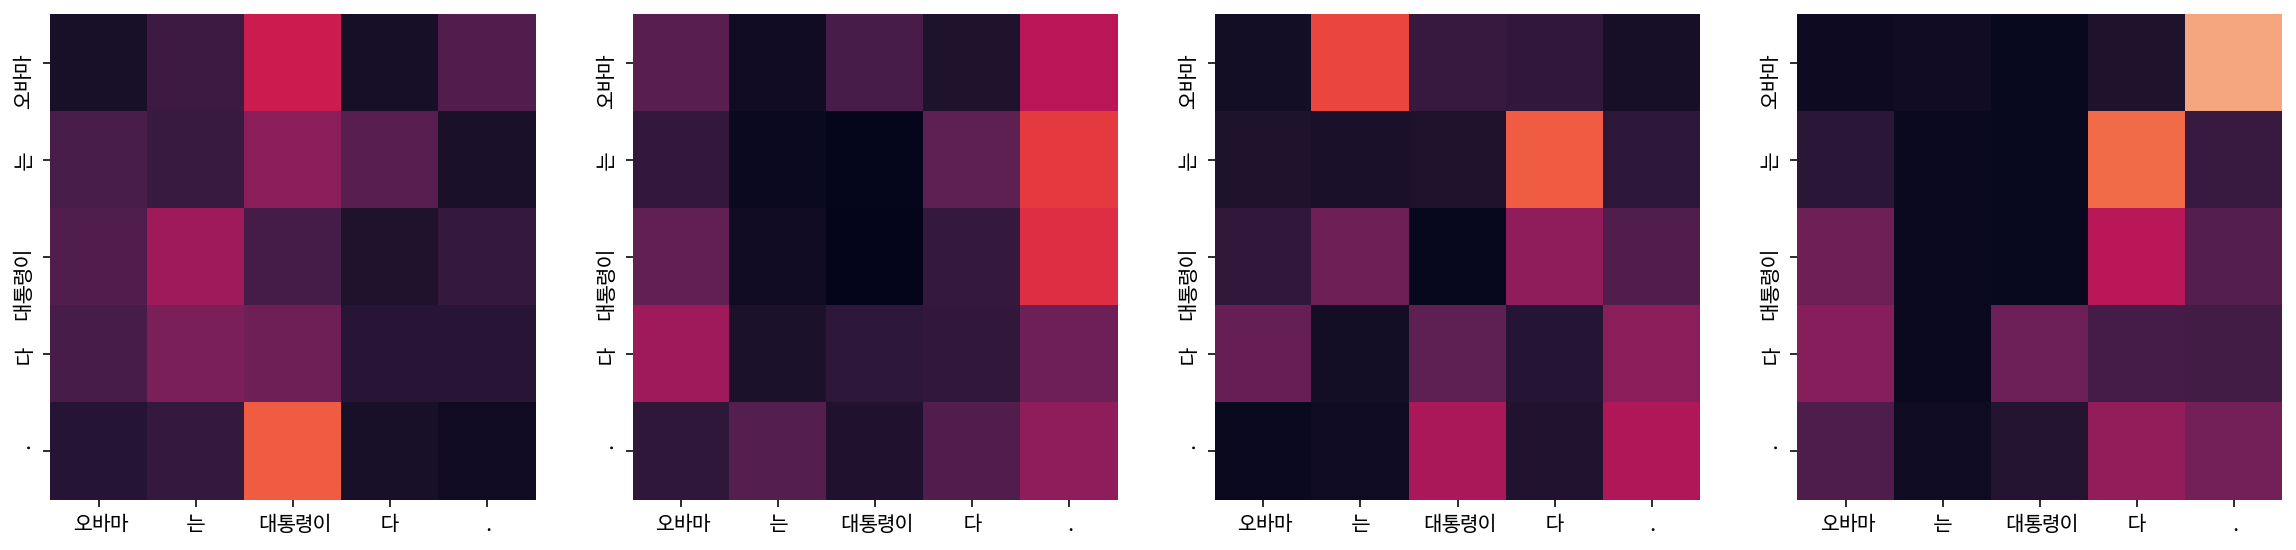

Decoder Self Layer 1


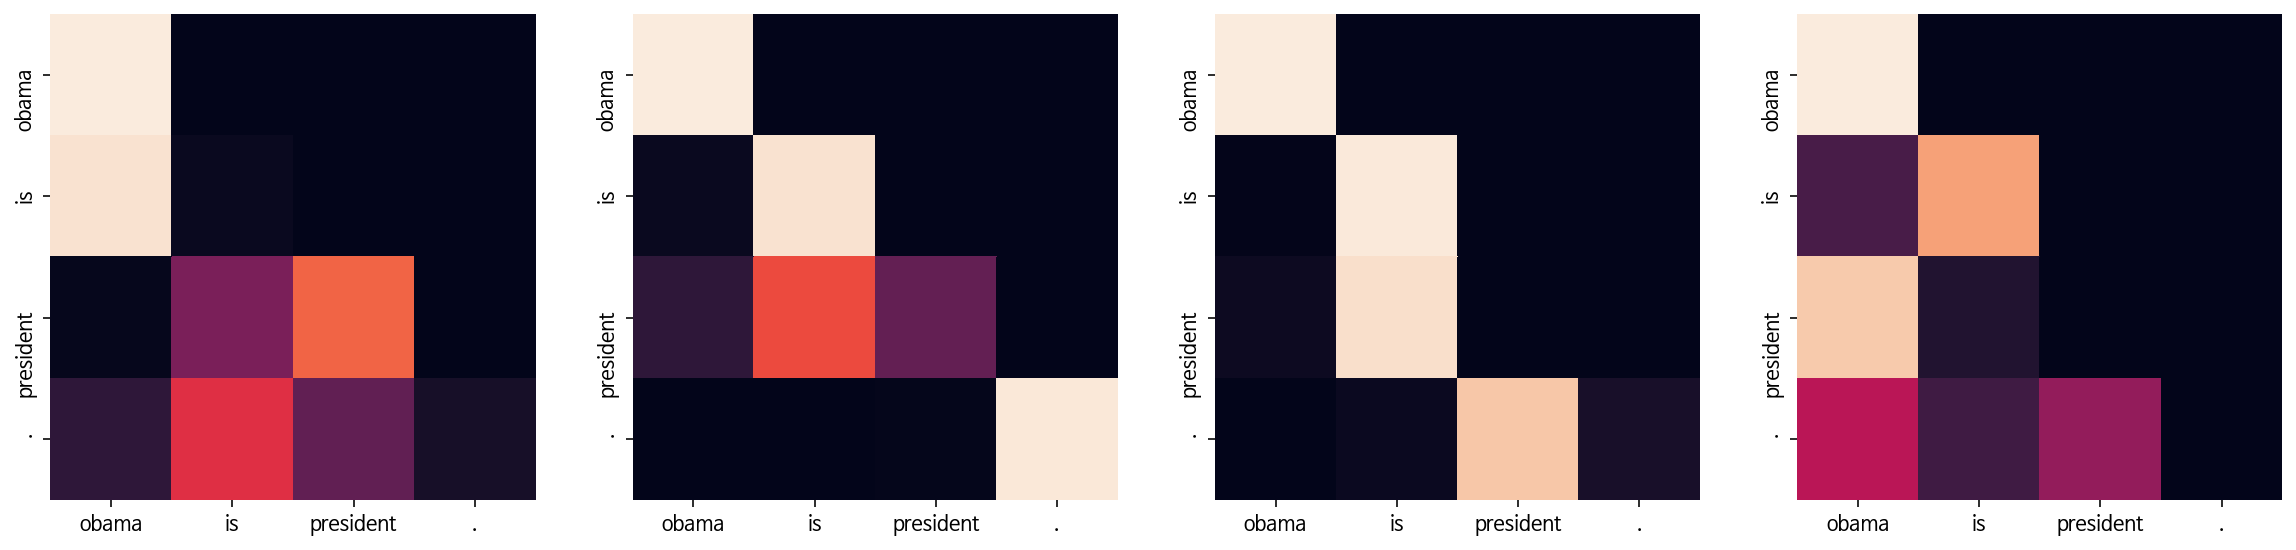

Decoder Src Layer 1


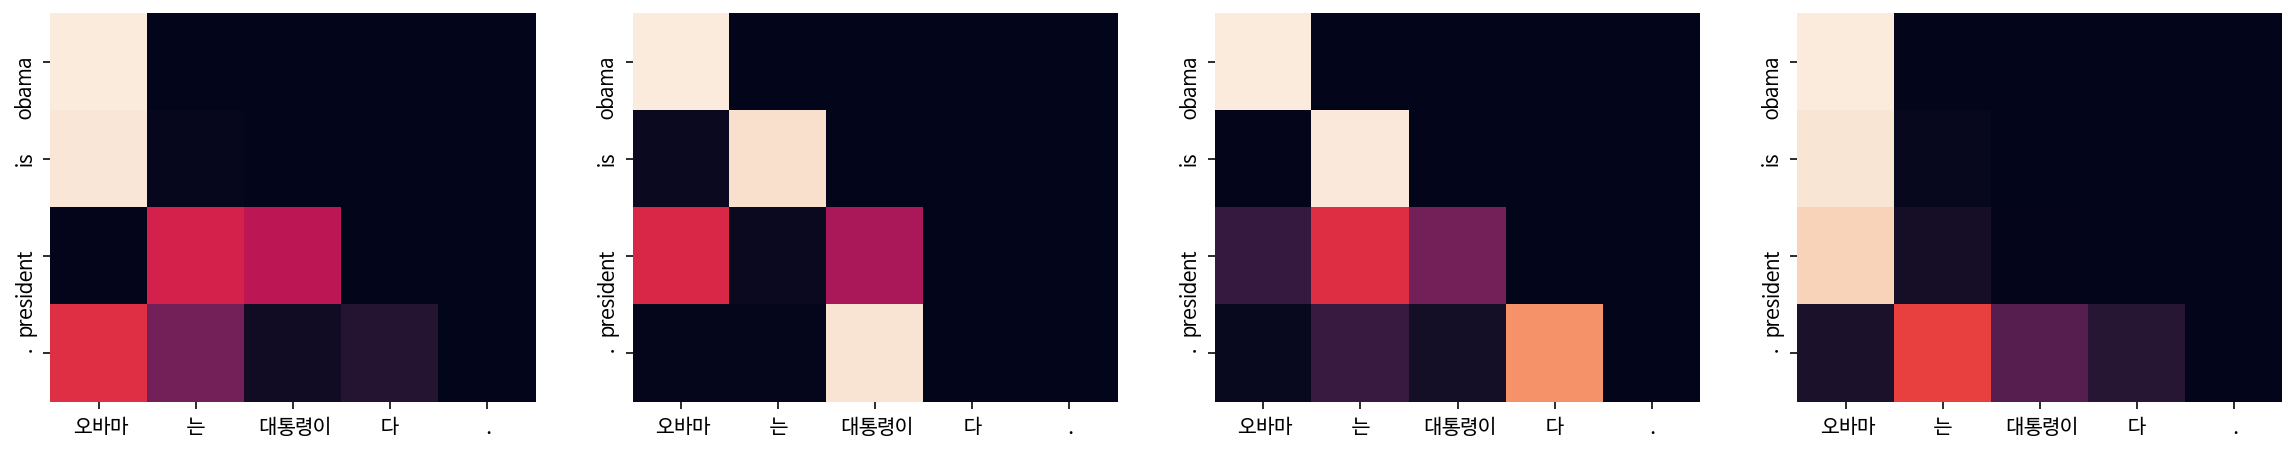

Decoder Self Layer 2


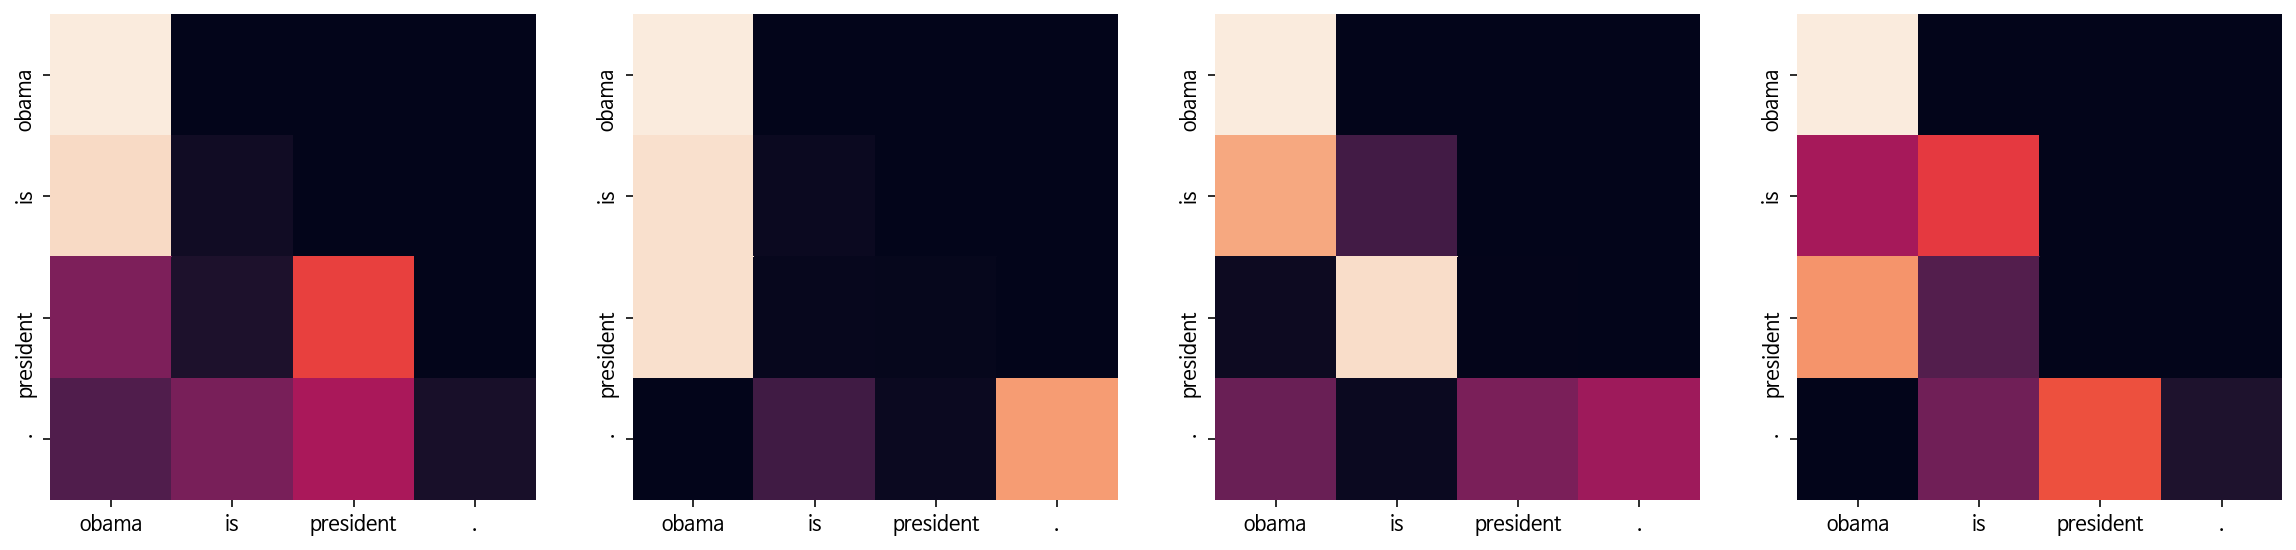

Decoder Src Layer 2


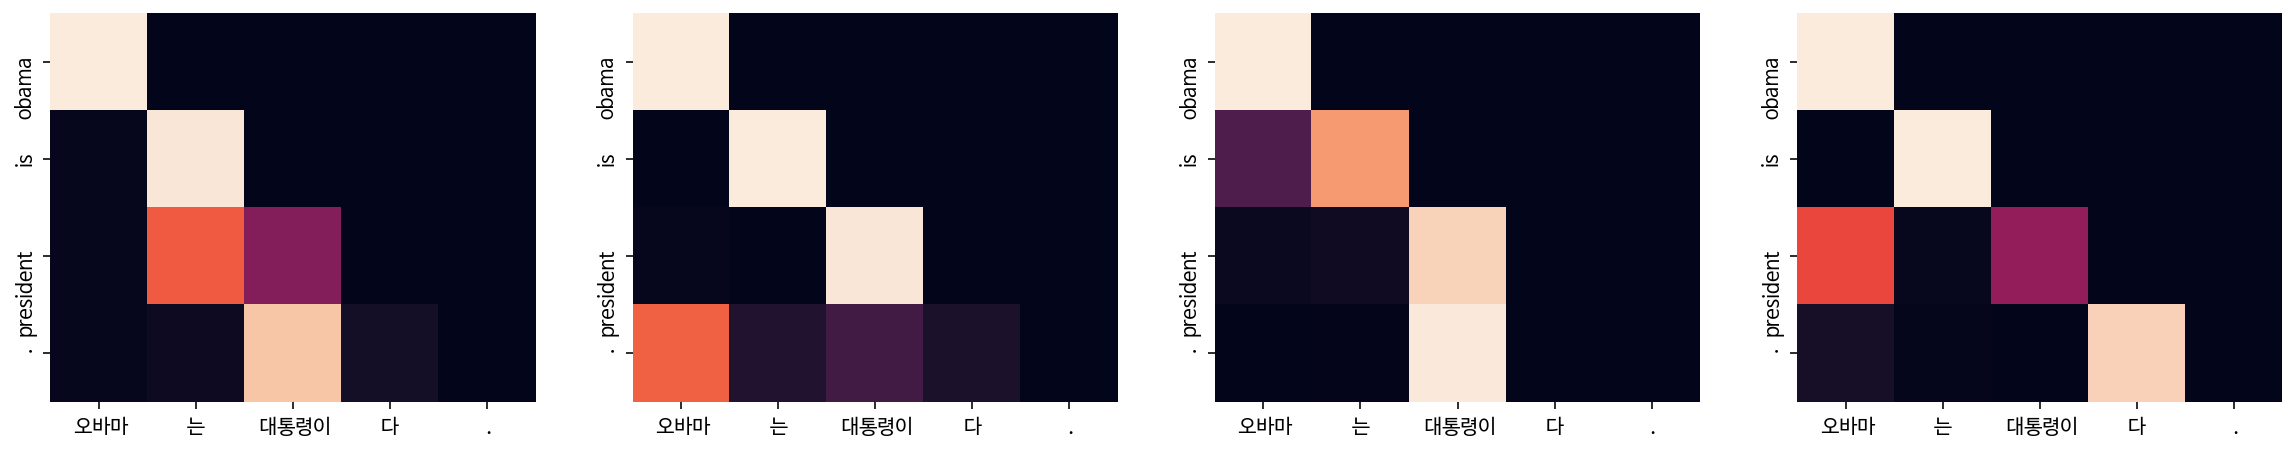

In [78]:
sentence = '오바마는 대통령이다.'
translate('오바마는 대통령이다.',transformer, ko_tokenizer, en_tokenizer,True)

1
50
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were at the seven serious debris .
Encoder Layer 1


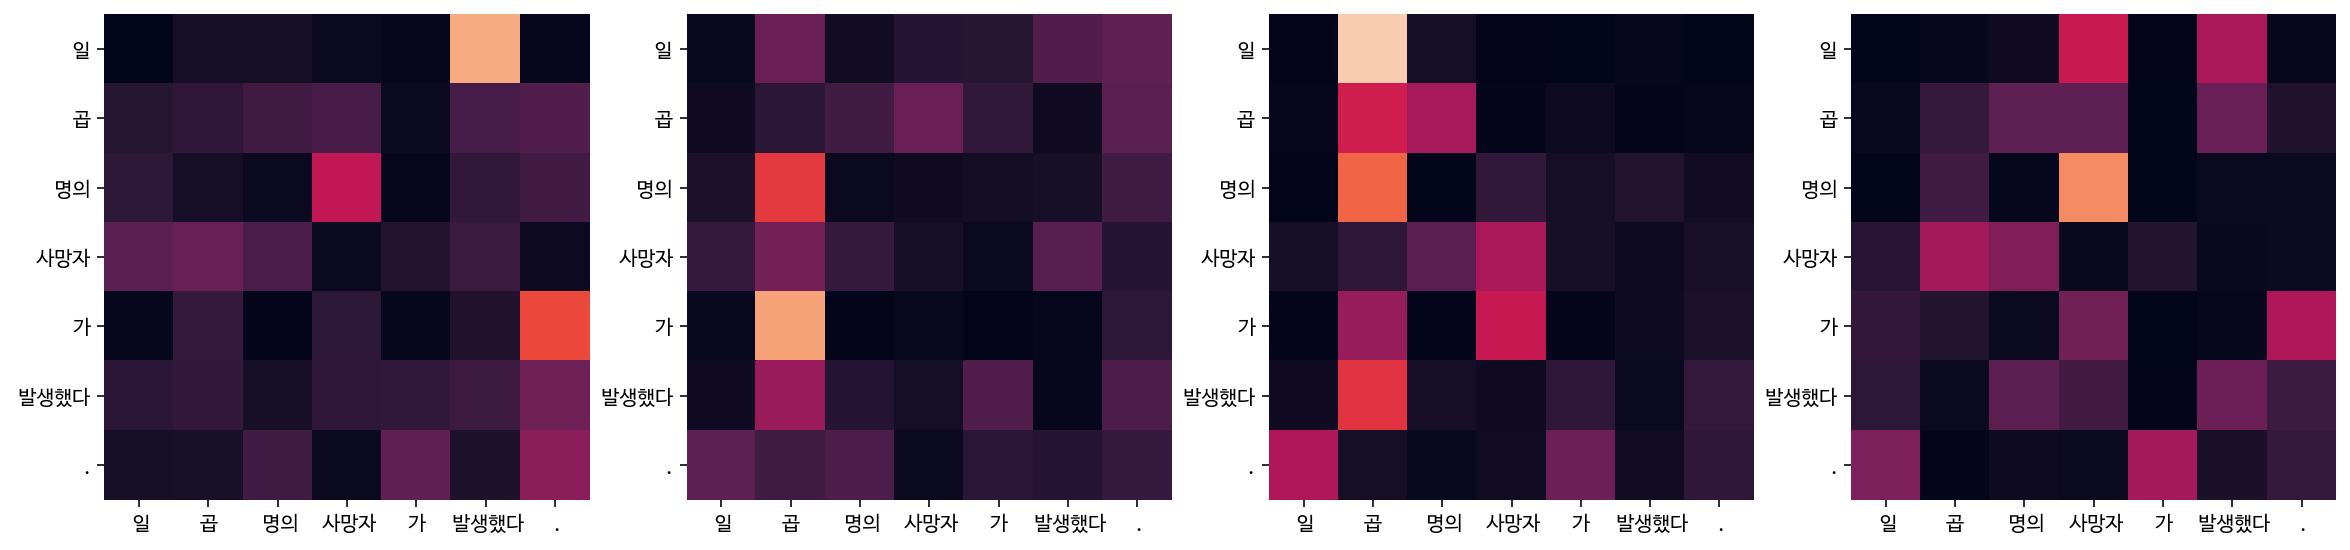

Encoder Layer 2


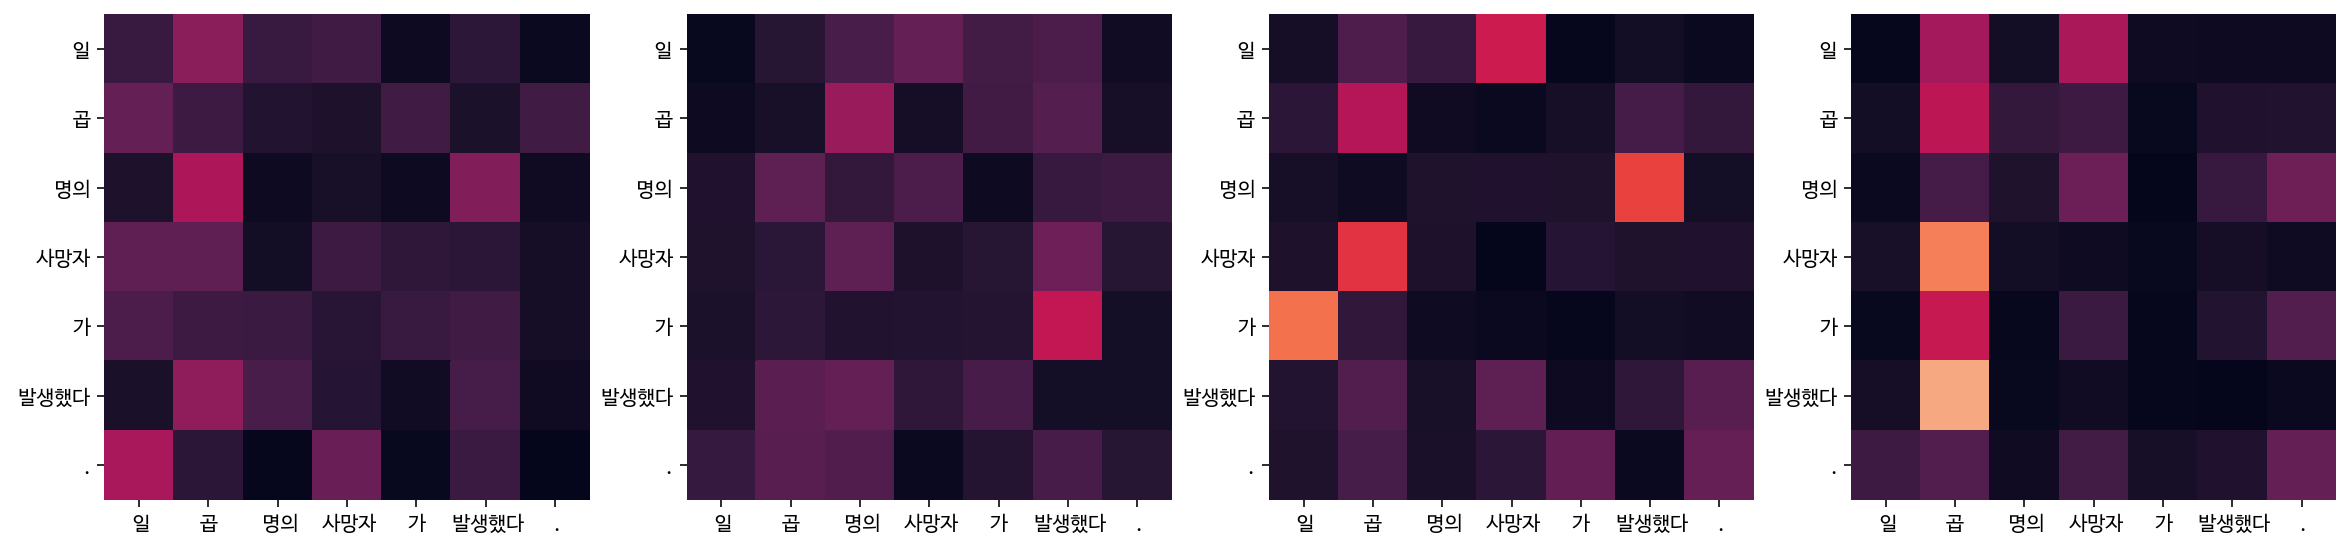

Decoder Self Layer 1


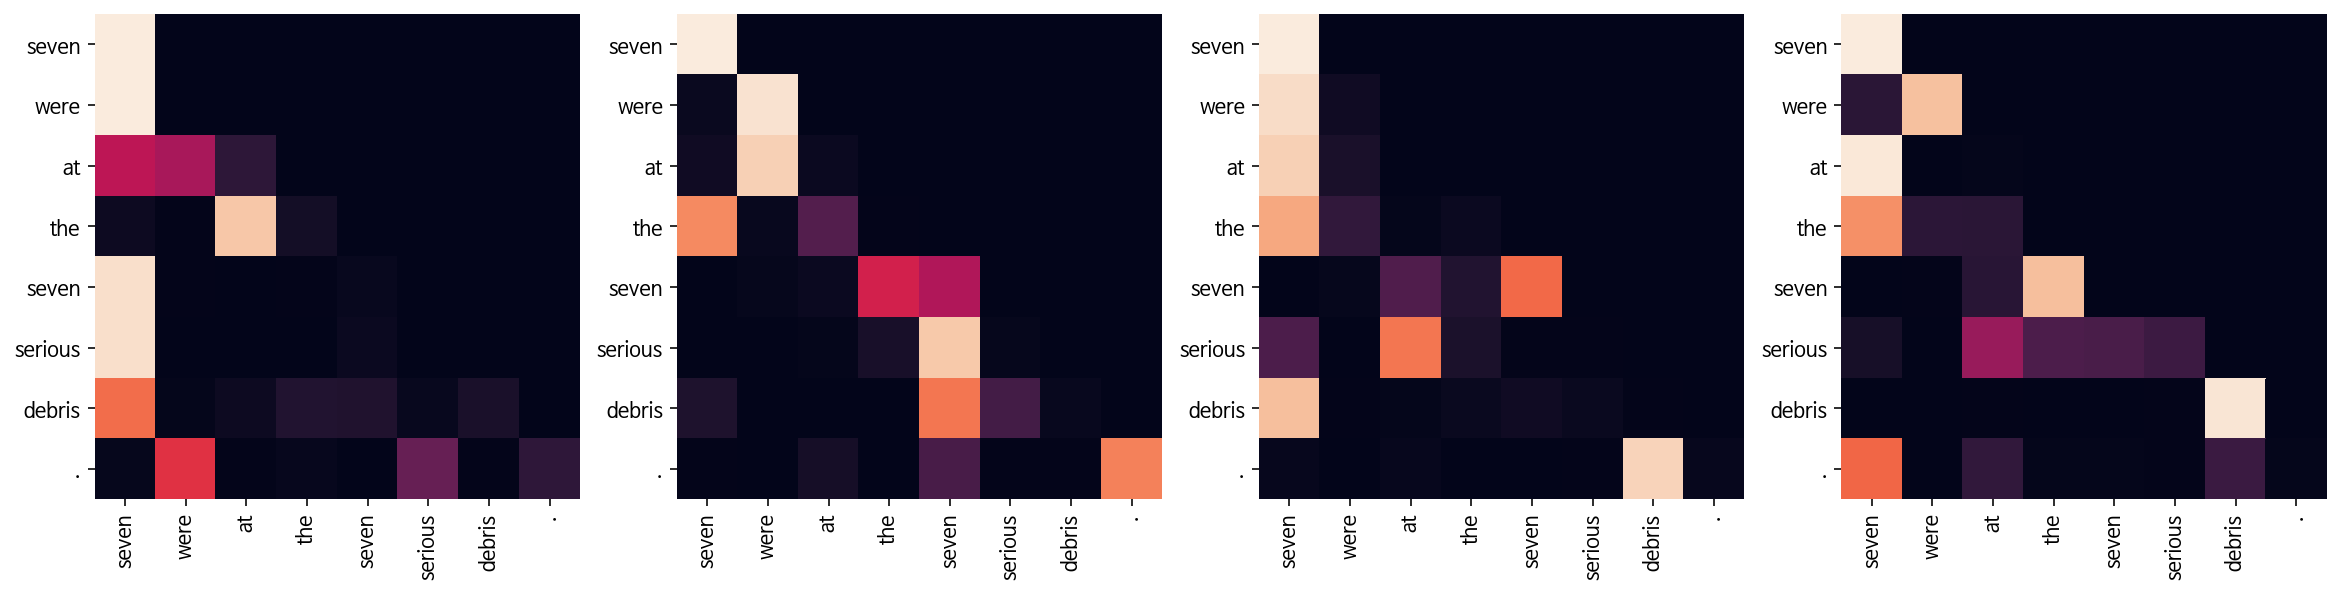

Decoder Src Layer 1


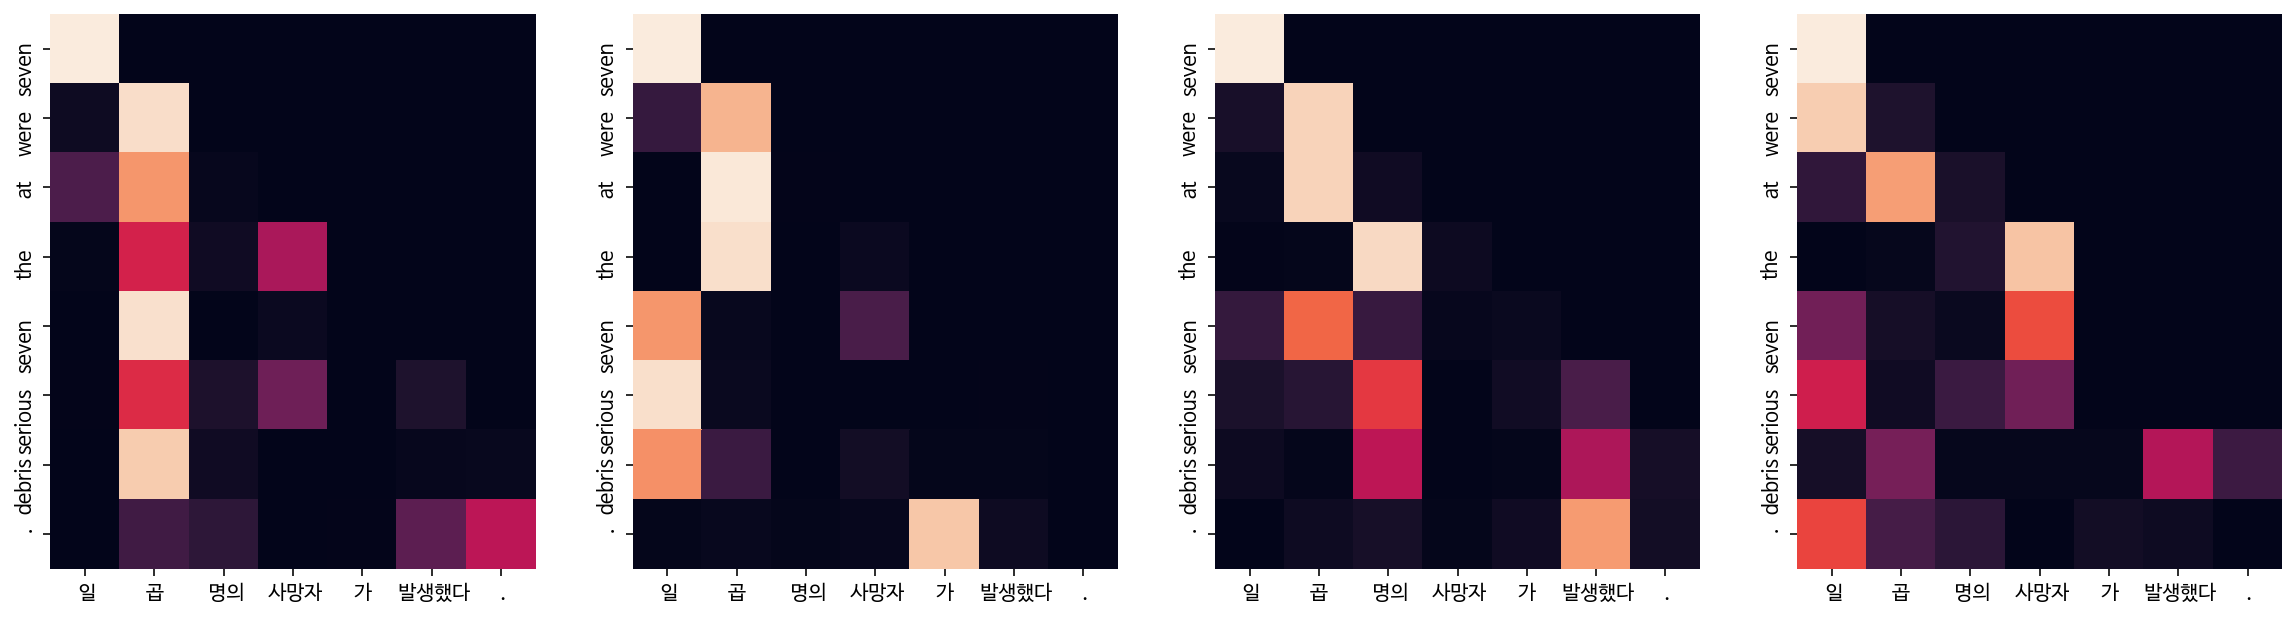

Decoder Self Layer 2


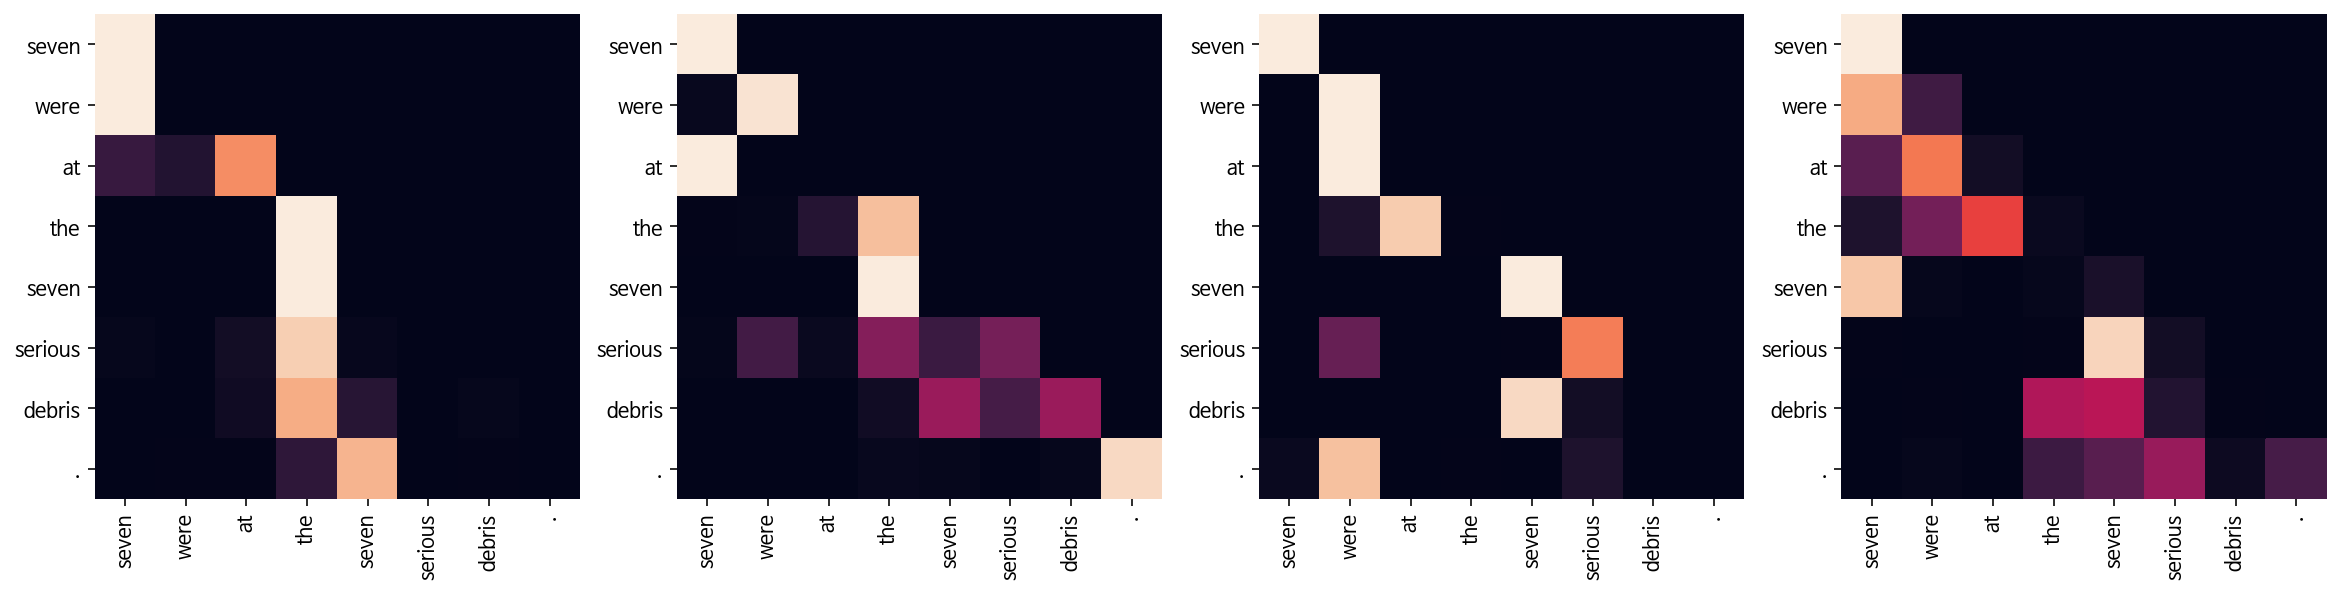

Decoder Src Layer 2


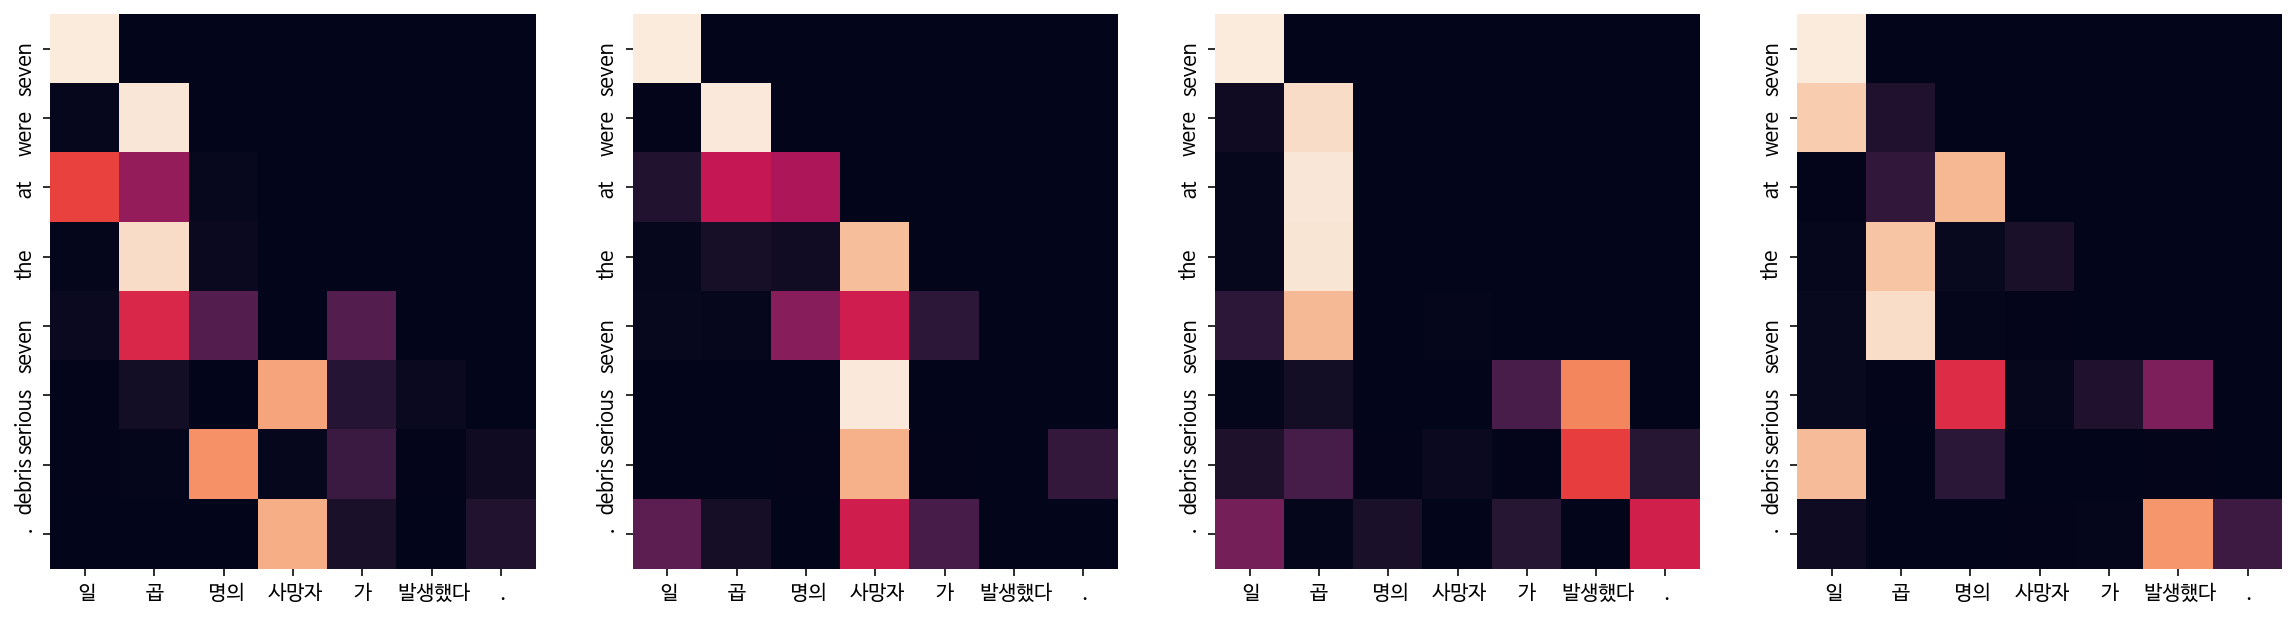

In [79]:
sentence = '일곱 명의 사망자가 발생했다.'
translate('일곱 명의 사망자가 발생했다.',transformer, ko_tokenizer, en_tokenizer,True)

# 고찰   
트랜스포머를 subclassing으로 접근하는 방법으로 다시 한 번 연습하는 과정이었다. 레이어마다 어떻게 단어들이 매칭되는지, 시각적으로도 어떤 단어에 attention되었는지 확인할 수 있었던 프로젝트였다. 어느정도 explainable AI란 것이 이런게 아닐까 싶다. 성능 증대까지는 어떤 하이퍼파라미터를 건드려야 제대로 작동하는지 확인이 힘들어서 많은 시도를 하지 못한 건 아쉽다... 